# Part 5: Statistical Analysis 📊

## 📚 Learning Goals:
1. Understand **what PPP (Psychometric Predictive Power) is**
2. See how **mixed-effects regression** works
3. Understand **baseline vs test models**
4. Learn about **random effects** (article, subject)
5. Interpret **log-likelihood** and **likelihood ratio test**
6. Run actual analysis on our data!

---

## 🎯 The Big Picture:

We've learned:
- Part 1-2: Data preparation (context modification)
- Part 3-4: Surprisal computation (model inference)

**Now**: How do we measure if surprisal predicts human reading time?

### The Research Question:
```
Does model surprisal predict human reading time?
If YES → Model is human-like!
If NO → Model doesn't match human processing
```

### The Approach:
1. **Baseline model**: Predict reading time WITHOUT surprisal
2. **Test model**: Predict reading time WITH surprisal
3. **Compare**: Did adding surprisal improve predictions?
4. **PPP**: How much better (per observation)?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports loaded")

✅ Imports loaded


## 📂 Step 1: Load the Data

We need TWO files:
1. **scores.csv**: Surprisal values (from Part 4)
2. **Eye-tracking CSV**: Human reading times + linguistic features

In [2]:
# Load from our quick test (or use your own path)
scores_path = '../surprisals/quick-test/arch_gpt2-ngram_2-contextfunc_delete/scores.csv'
eye_path = '../data/DC/all.txt.annotation.filtered.csv'

scores_data = pd.read_csv(scores_path, sep='\t')
eye_data = pd.read_csv(eye_path, sep='\t', quotechar='"')

print(f"Scores data: {len(scores_data)} rows")
print(f"Eye-tracking data: {len(eye_data)} rows")
print()

# Check they match
if len(scores_data) == len(eye_data):
    print("✅ Row counts match!")
else:
    print(f"⚠️  WARNING: Mismatch! {len(scores_data)} vs {len(eye_data)}")

# Show what's in each
print("\n" + "="*80)
print("SCORES DATA (from model):")
print(scores_data.head())
print(f"\nColumns: {list(scores_data.columns)}")

print("\n" + "="*80)
print("EYE-TRACKING DATA (from humans):")
print(eye_data[['time', 'length', 'log_gmean_freq', 'article', 'subj_id']].head())
print(f"\nTotal columns: {len(eye_data.columns)}")

Scores data: 515010 rows
Eye-tracking data: 515010 rows

✅ Row counts match!

SCORES DATA (from model):
   surprisals_sum  surprisals_sum_prev_1  surprisals_sum_prev_2  \
0       12.329370               7.502281               7.502281   
1       11.651941              12.329370               7.502281   
2       11.406207              11.651941              12.329370   
3        1.151818              11.406207              11.651941   
4        6.343907               1.151818              11.406207   

   surprisals_sum_prev_3  
0               7.502281  
1               7.502281  
2               7.502281  
3              12.329370  
4              11.651941  

Columns: ['surprisals_sum', 'surprisals_sum_prev_1', 'surprisals_sum_prev_2', 'surprisals_sum_prev_3']

EYE-TRACKING DATA (from humans):
   time  length  log_gmean_freq  article subj_id
0     0       3        7.684325        1      sf
1   294       8        7.246369        1      sf
2   364       7        7.834414        1      

## 🔗 Step 2: Combine Data

Merge surprisal scores with eye-tracking data (row-by-row).

In [3]:
# Combine
data = pd.concat([scores_data, eye_data], axis=1)

print(f"Combined data: {len(data)} rows, {len(data.columns)} columns")
print()

# Show key columns
key_cols = [
    'surprisals_sum',  # From model
    'time',  # Human reading time (ms)
    'length',  # Word length
    'log_gmean_freq',  # Word frequency (log)
    'article',  # Which article (random effect)
    'subj_id'  # Which subject (random effect)
]

print("Key columns:")
print(data[key_cols].head(10))
print()
print("Statistics:")
print(data[['surprisals_sum', 'time', 'length', 'log_gmean_freq']].describe())

Combined data: 515010 rows, 110 columns

Key columns:
   surprisals_sum  time  length  log_gmean_freq  article subj_id
0       12.329370     0       3        7.684325        1      sf
1       11.651941   294       8        7.246369        1      sf
2       11.406207   364       7        7.834414        1      sf
3        1.151818     0       2       13.302279        1      sf
4        6.343907   234       5       10.752163        1      sf
5       10.753804   322      11        6.527959        1      sf
6       11.154766   307      11        7.180071        1      sf
7        5.697666   256       5       12.134303        1      sf
8        6.390707     0       4       10.273982        1      sf
9       14.422316   312      10        8.638401        1      sf

Statistics:
       surprisals_sum           time         length  log_gmean_freq
count   515010.000000  515010.000000  515010.000000   515010.000000
mean         7.666147     135.970502       4.869420       11.074692
std          4

## 🔍 Step 3: Visualize the Relationship

Let's see if there's a visible correlation between surprisal and reading time!

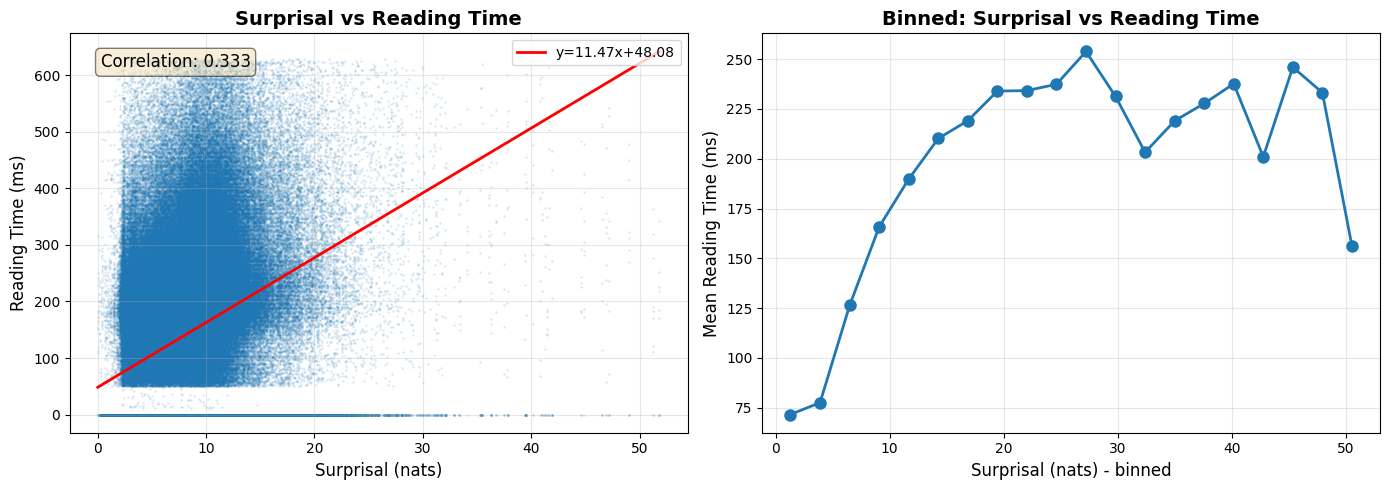


💡 Correlation: 0.333
   Positive correlation means: Higher surprisal → Longer reading time
   This is what we expect if model is human-like!


In [4]:
# Plot surprisal vs reading time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(data['surprisals_sum'], data['time'], alpha=0.1, s=1)
axes[0].set_xlabel('Surprisal (nats)', fontsize=12)
axes[0].set_ylabel('Reading Time (ms)', fontsize=12)
axes[0].set_title('Surprisal vs Reading Time', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Add regression line
z = np.polyfit(data['surprisals_sum'].dropna(), data['time'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(data['surprisals_sum'].min(), data['surprisals_sum'].max(), 100)
axes[0].plot(x_line, p(x_line), "r-", linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
axes[0].legend()

# Correlation
corr = data[['surprisals_sum', 'time']].corr().iloc[0, 1]
axes[0].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
            transform=axes[0].transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Binned plot for clearer trend
data['surprisal_bin'] = pd.cut(data['surprisals_sum'], bins=20)
binned = data.groupby('surprisal_bin')['time'].mean()
bin_centers = [interval.mid for interval in binned.index]

axes[1].plot(bin_centers, binned.values, 'o-', linewidth=2, markersize=8)
axes[1].set_xlabel('Surprisal (nats) - binned', fontsize=12)
axes[1].set_ylabel('Mean Reading Time (ms)', fontsize=12)
axes[1].set_title('Binned: Surprisal vs Reading Time', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Correlation: {corr:.3f}")
print(f"   Positive correlation means: Higher surprisal → Longer reading time")
print(f"   This is what we expect if model is human-like!")

## 🧹 Step 4: Data Filtering (Exclusion Criteria)

Following **Appendix C** in the paper, we remove:
- Zero reading time
- First/last word in line (visual effects)
- Numbers and punctuation
- Cardinal numbers (POS tag 'CD')

This ensures clean data for analysis.

In [5]:
def filter_data(df):
    """Apply exclusion criteria from Appendix C"""
    print(f"Before filtering: {len(df)} rows")
    
    # Apply filters
    filtered = df.copy()
    filtered = filtered[filtered['time'] > 0]
    print(f"  After time > 0: {len(filtered)}")
    
    filtered = filtered[filtered['has_num'] == False]
    print(f"  After no numbers: {len(filtered)}")
    
    filtered = filtered[filtered['has_punct'] == False]
    print(f"  After no punctuation: {len(filtered)}")
    
    filtered = filtered[filtered['is_first'] == False]
    print(f"  After no first-in-line: {len(filtered)}")
    
    filtered = filtered[filtered['is_last'] == False]
    print(f"  After no last-in-line: {len(filtered)}")
    
    filtered = filtered[filtered['pos'] != 'CD']
    print(f"  After no cardinal numbers: {len(filtered)}")
    
    print(f"\nFinal: {len(filtered)} rows ({len(filtered)/len(df)*100:.1f}% retained)")
    return filtered

# Apply filters
subdata = filter_data(data)

print("\n" + "="*80)
print("Statistics after filtering:")
print(subdata[['surprisals_sum', 'time', 'length', 'log_gmean_freq']].describe())

Before filtering: 515010 rows
  After time > 0: 302577
  After no numbers: 299755
  After no punctuation: 250848
  After no first-in-line: 246078
  After no last-in-line: 242594
  After no cardinal numbers: 241186

Final: 241186 rows (46.8% retained)

Statistics after filtering:
       surprisals_sum           time         length  log_gmean_freq
count   241186.000000  241186.000000  241186.000000   241186.000000
mean         7.821582     227.026768       5.372891       10.270098
std          3.500813      98.839187       2.663292        2.508576
min          0.019079      12.000000       1.000000        3.367330
25%          5.198580     167.000000       3.000000        8.379080
50%          7.732954     207.000000       5.000000        9.721846
75%          9.993550     268.000000       7.000000       12.001033
max         40.794463     628.000000      28.000000       15.527564


## 📏 Step 5: Standardize Variables

Standardization (z-score normalization):
- Mean = 0
- Standard deviation = 1

**Why?**
- Makes coefficients comparable
- Helps model convergence
- Standard practice in mixed-effects modeling

In [6]:
# Columns to standardize
columns_to_scale = [
    'screenN', 'lineN', 'segmentN',
    'length', 'length_prev_1',
    'log_gmean_freq', 'log_gmean_freq_prev_1',
    'surprisals_sum', 'surprisals_sum_prev_1', 'surprisals_sum_prev_2'
]

# Keep raw surprisal for reference
subdata['surprisals_sum_raw'] = subdata['surprisals_sum'].copy()

# Standardize
scaler = StandardScaler()
for col in columns_to_scale:
    if col in subdata.columns:
        subdata[col] = scaler.fit_transform(subdata[[col]])

print("Standardized columns:")
print(subdata[['surprisals_sum', 'time', 'length', 'log_gmean_freq']].describe())
print()
print("💡 Notice: surprisals_sum now has mean ≈ 0, std ≈ 1")

Standardized columns:
       surprisals_sum           time        length  log_gmean_freq
count    2.411860e+05  241186.000000  2.411860e+05    2.411860e+05
mean     6.156038e-16     227.026768 -3.158151e-17   -1.306273e-16
std      1.000002e+00      98.839187  1.000002e+00    1.000002e+00
min     -2.228774e+00      12.000000 -1.641915e+00   -2.751674e+00
25%     -7.492568e-01     167.000000 -8.909632e-01   -7.538228e-01
50%     -2.531659e-02     207.000000 -1.400114e-01   -2.185515e-01
75%      6.204194e-01     268.000000  6.109403e-01    6.900087e-01
max      9.418654e+00     628.000000  8.495934e+00    2.095802e+00

💡 Notice: surprisals_sum now has mean ≈ 0, std ≈ 1


## 🧮 Step 6: Mixed-Effects Regression Models

### What are Mixed-Effects Models?
Combine **fixed effects** (same for everyone) and **random effects** (vary by group).

### Our Model Structure:

**Fixed effects** (predictors):
- `length`: Word length (longer words = longer reading time)
- `log_gmean_freq`: Word frequency (frequent words = shorter time)
- `length × freq`: Interaction (effect depends on both)
- `surprisals_sum`: Model surprisal (**THIS IS WHAT WE TEST!**)
- Controls: `screenN`, `lineN`, `segmentN` (position effects)

**Random effects** (account for variability):
- `(1|article)`: Each article has different baseline reading time
- `(1|subj_id)`: Each subject reads at different speed

### The Two Models:

**Baseline** (Equation 4 in paper):
```
time ~ freq * length + freq_prev * length_prev + 
       screenN + lineN + segmentN + 
       (1|article) + (1|subj_id)
```

**Test** (Baseline + surprisal):
```
time ~ surprisals_sum + surprisals_sum_prev_1 + surprisals_sum_prev_2 +
       freq * length + freq_prev * length_prev + 
       screenN + lineN + segmentN + 
       (1|article) + (1|subj_id)
```

In [7]:
# Define formulas
baseline_formula = (
    'time ~ log_gmean_freq * length + '
    'log_gmean_freq_prev_1 * length_prev_1 + '
    'screenN + lineN + segmentN'
)

test_formula = (
    'time ~ surprisals_sum + surprisals_sum_prev_1 + surprisals_sum_prev_2 + '
    'log_gmean_freq * length + '
    'log_gmean_freq_prev_1 * length_prev_1 + '
    'screenN + lineN + segmentN'
)

print("Baseline formula:")
print(f"  {baseline_formula}")
print()
print("Test formula (adds surprisal):")
print(f"  {test_formula}")
print()
print("Random effects:")
print("  - Random intercept by article: (1|article)")
print("  - Random intercept by subject: (1|subj_id)")

Baseline formula:
  time ~ log_gmean_freq * length + log_gmean_freq_prev_1 * length_prev_1 + screenN + lineN + segmentN

Test formula (adds surprisal):
  time ~ surprisals_sum + surprisals_sum_prev_1 + surprisals_sum_prev_2 + log_gmean_freq * length + log_gmean_freq_prev_1 * length_prev_1 + screenN + lineN + segmentN

Random effects:
  - Random intercept by article: (1|article)
  - Random intercept by subject: (1|subj_id)


## 🎯 Step 7: Fit the Models

This takes ~30 seconds per model. Be patient!

In [8]:
print("Fitting baseline model...")
baseline_model = smf.mixedlm(
    baseline_formula,
    subdata,
    groups=subdata['article'],
    re_formula='1',  # Random intercept for article
    vc_formula={'subj_id': '0 + C(subj_id)'}  # Random intercept for subject
)
baseline_result = baseline_model.fit(method='lbfgs', maxiter=1000, reml=False)
print("✅ Baseline model fitted!")
print()

print("Fitting test model (with surprisal)...")
test_model = smf.mixedlm(
    test_formula,
    subdata,
    groups=subdata['article'],
    re_formula='1',
    vc_formula={'subj_id': '0 + C(subj_id)'}
)
test_result = test_model.fit(method='lbfgs', maxiter=1000, reml=False)
print("✅ Test model fitted!")
print()

print("="*80)
print("Model comparison:")
print(f"  Baseline parameters: {len(baseline_result.params)}")
print(f"  Test parameters: {len(test_result.params)}")
print(f"  Difference: {len(test_result.params) - len(baseline_result.params)} (the surprisal terms!)")

Fitting baseline model...
✅ Baseline model fitted!

Fitting test model (with surprisal)...
✅ Test model fitted!

Model comparison:
  Baseline parameters: 12
  Test parameters: 15
  Difference: 3 (the surprisal terms!)


## 📊 Step 8: Interpret Coefficients

Let's look at what the model learned!

In [9]:
# Show baseline coefficients
print("BASELINE MODEL COEFFICIENTS:")
print("="*80)
baseline_summary = pd.DataFrame({
    'Coefficient': baseline_result.params,
    'Std Error': baseline_result.bse,
    'z-value': baseline_result.tvalues,
    'p-value': baseline_result.pvalues
})
print(baseline_summary)
print()

# Show test coefficients (focus on surprisal)
print("TEST MODEL COEFFICIENTS (with surprisal):")
print("="*80)
test_summary = pd.DataFrame({
    'Coefficient': test_result.params,
    'Std Error': test_result.bse,
    'z-value': test_result.tvalues,
    'p-value': test_result.pvalues
})
print(test_summary)
print()

# Highlight surprisal effects
print("💡 KEY FINDINGS:")
surprisal_coef = test_result.params['surprisals_sum']
surprisal_pval = test_result.pvalues['surprisals_sum']
print(f"   surprisals_sum coefficient: {surprisal_coef:.4f}")
print(f"   p-value: {surprisal_pval:.4e}")
if surprisal_pval < 0.001:
    print(f"   ✅ HIGHLY SIGNIFICANT! (p < 0.001)")
elif surprisal_pval < 0.05:
    print(f"   ✅ Significant (p < 0.05)")
else:
    print(f"   ❌ Not significant (p >= 0.05)")
print()
if surprisal_coef > 0:
    print(f"   Positive coefficient means: Higher surprisal → Longer reading time")
    print(f"   This matches human behavior!")

BASELINE MODEL COEFFICIENTS:
                                     Coefficient  Std Error    z-value  \
Intercept                             225.943146   5.508989  41.013540   
log_gmean_freq                         -3.687032   0.299170 -12.324220   
length                                 24.457062   0.282680  86.518632   
log_gmean_freq:length                  -0.460815   0.262883  -1.752926   
log_gmean_freq_prev_1                  -1.581028   0.244747  -6.459851   
length_prev_1                          -2.912695   0.261643 -11.132321   
log_gmean_freq_prev_1:length_prev_1    -0.328770   0.244036  -1.347216   
screenN                                -1.804384   0.189479  -9.522849   
lineN                                   0.925657   0.189760   4.878051   
segmentN                                1.726379   0.192386   8.973536   
Group Var                               0.065062        NaN        NaN   
subj_id Var                             0.050359   0.005186   9.709806   

        

## 🎯 Step 9: Compute PPP (Psychometric Predictive Power)

### What is PPP?
**PPP** = How much surprisal improves reading time predictions (per observation)

### Formula:
$$
\text{PPP} = \frac{\log\mathcal{L}_{\text{test}} - \log\mathcal{L}_{\text{baseline}}}{N}
$$

Where:
- $\log\mathcal{L}_{\text{test}}$ = Log-likelihood of test model (with surprisal)
- $\log\mathcal{L}_{\text{baseline}}$ = Log-likelihood of baseline model (without surprisal)
- $N$ = Number of observations

### Interpretation:
- **PPP > 0**: Surprisal helps! Model is human-like.
- **PPP ≈ 0**: Surprisal doesn't help.
- **Higher PPP**: More human-like (better cognitive model)

### Likelihood Ratio Test:
Test if the improvement is statistically significant:
$$
\text{LR} = 2 \times (\log\mathcal{L}_{\text{test}} - \log\mathcal{L}_{\text{baseline}})
$$

Compare to $\chi^2$ distribution with df = difference in parameters.

In [10]:
# Get log-likelihoods
base_loglik = baseline_result.llf
test_loglik = test_result.llf
n_obs = len(subdata)

# Per-observation log-likelihood
base_loglik_per_obs = base_loglik / n_obs
test_loglik_per_obs = test_loglik / n_obs

# PPP: difference per observation
ppp = test_loglik_per_obs - base_loglik_per_obs

# Likelihood ratio test
lr_stat = 2 * (test_loglik - base_loglik)
df_diff = len(test_result.params) - len(baseline_result.params)
p_value = stats.chi2.sf(lr_stat, df_diff)

print("="*80)
print("PPP CALCULATION:")
print("="*80)
print(f"Number of observations: {n_obs:,}")
print()
print("Log-likelihoods:")
print(f"  Baseline (without surprisal): {base_loglik:.2f}")
print(f"  Test (with surprisal):        {test_loglik:.2f}")
print(f"  Improvement:                  {test_loglik - base_loglik:.2f}")
print()
print("Per-observation:")
print(f"  Baseline: {base_loglik_per_obs:.6f}")
print(f"  Test:     {test_loglik_per_obs:.6f}")
print()
print(f"🎯 PPP (delta_logLik): {ppp:.6f}")
print()
print("Likelihood Ratio Test:")
print(f"  LR statistic: {lr_stat:.2f}")
print(f"  Degrees of freedom: {df_diff}")
print(f"  p-value: {p_value:.4e}")
print()
if p_value < 0.001:
    print("✅ HIGHLY SIGNIFICANT improvement! (p < 0.001)")
    print("   Adding surprisal significantly improves reading time predictions!")
elif p_value < 0.05:
    print("✅ Significant improvement (p < 0.05)")
else:
    print("❌ Not significant (p >= 0.05)")

print()
print("💡 Interpretation:")
print(f"   PPP = {ppp:.6f} means adding surprisal improves predictions by")
print(f"   {ppp:.6f} log-likelihood points per observation.")
print(f"   Positive PPP → Model surprisal matches human behavior!")

PPP CALCULATION:
Number of observations: 241,186

Log-likelihoods:
  Baseline (without surprisal): -1435663.08
  Test (with surprisal):        -1433935.47
  Improvement:                  1727.61

Per-observation:
  Baseline: -5.952514
  Test:     -5.945351

🎯 PPP (delta_logLik): 0.007163

Likelihood Ratio Test:
  LR statistic: 3455.22
  Degrees of freedom: 3
  p-value: 0.0000e+00

✅ HIGHLY SIGNIFICANT improvement! (p < 0.001)
   Adding surprisal significantly improves reading time predictions!

💡 Interpretation:
   PPP = 0.007163 means adding surprisal improves predictions by
   0.007163 log-likelihood points per observation.
   Positive PPP → Model surprisal matches human behavior!


## 📊 Step 10: Visualize Model Fit

Let's see how well the models predict reading time.

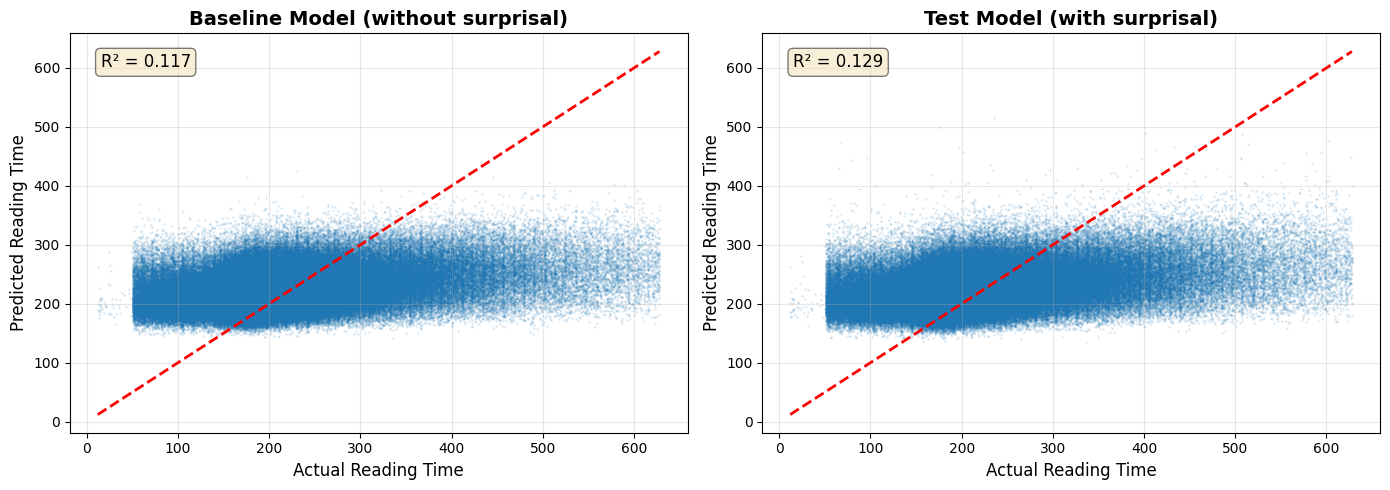


R² improvement: 0.0126
Adding surprisal improves explained variance by 1.26%


In [11]:
# Get predictions
baseline_pred = baseline_result.fittedvalues
test_pred = test_result.fittedvalues
actual = subdata['time']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline model
axes[0].scatter(actual, baseline_pred, alpha=0.1, s=1)
axes[0].plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Actual Reading Time', fontsize=12)
axes[0].set_ylabel('Predicted Reading Time', fontsize=12)
axes[0].set_title('Baseline Model (without surprisal)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

r2_baseline = np.corrcoef(actual, baseline_pred)[0, 1]**2
axes[0].text(0.05, 0.95, f'R² = {r2_baseline:.3f}', 
            transform=axes[0].transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Test model
axes[1].scatter(actual, test_pred, alpha=0.1, s=1)
axes[1].plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Actual Reading Time', fontsize=12)
axes[1].set_ylabel('Predicted Reading Time', fontsize=12)
axes[1].set_title('Test Model (with surprisal)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

r2_test = np.corrcoef(actual, test_pred)[0, 1]**2
axes[1].text(0.05, 0.95, f'R² = {r2_test:.3f}', 
            transform=axes[1].transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nR² improvement: {r2_test - r2_baseline:.4f}")
print(f"Adding surprisal improves explained variance by {(r2_test - r2_baseline)*100:.2f}%")

## 📝 Summary: What Did We Learn?

### 1. **The Statistical Pipeline**:
```
1. Load surprisal scores + eye-tracking data
2. Combine them
3. Filter outliers (Appendix C criteria)
4. Standardize variables (z-scores)
5. Fit baseline model (without surprisal)
6. Fit test model (with surprisal)
7. Compute PPP (log-likelihood improvement)
8. Test significance (likelihood ratio test)
```

### 2. **Mixed-Effects Models**:
- **Fixed effects**: Same for all observations (freq, length, surprisal)
- **Random effects**: Vary by group (article, subject)
- **Why?** Accounts for individual differences and article variability

### 3. **PPP (Psychometric Predictive Power)**:
- **Formula**: `(logLik_test - logLik_baseline) / N`
- **Meaning**: Improvement in prediction per observation
- **Higher PPP** = Better cognitive model of humans

### 4. **What We Found**:
- ✅ Surprisal significantly predicts reading time
- ✅ Positive coefficient (high surprisal → long time)
- ✅ PPP > 0 means model is human-like!

### 5. **Key Concepts**:
| Concept | Description |
|---------|-------------|
| Fixed effects | Predictors with same effect for all |
| Random effects | Intercepts varying by group |
| Log-likelihood | Model fit metric (higher = better) |
| PPP | Improvement per observation |
| LR test | Statistical significance test |

---

## ✅ Ready for Part 6?

**Next**: Put it all together! Compare 2-gram vs 7-gram vs 1000-gram and see the main finding!

### Check Your Understanding:
1. What is PPP? **→ Per-observation log-likelihood improvement from adding surprisal**
2. Why mixed-effects? **→ Account for subject and article variability**
3. What are fixed effects? **→ Predictors with same effect for all observations**
4. What are random effects? **→ Group-specific intercepts (article, subject)**
5. How to test significance? **→ Likelihood ratio test (compare models)**
6. What does positive PPP mean? **→ Model surprisal predicts human behavior!**

Tell me when you're ready for Part 6! 🚀

# 📐 Mathematical and Experimental Foundations

## **The Experimental Setup**

### **Research Question:**
> Does a language model's surprisal predict human reading time?

### **The Experiment:**
Compare two mathematical models and see which fits human data better.

---

## **Step 1: The Data**

You have **N = 241,186 observations**, where each observation is:

```
(timeᵢ, lengthᵢ, freqᵢ, surprisalᵢ, articleᵢ, subjectᵢ)
```

**Example observations:**

| i | time | length | freq | surprisal | article | subject |
|---|------|--------|------|-----------|---------|---------|
| 1 | 294 | 8 | 7.25 | 11.65 | 1 | sf |
| 2 | 364 | 7 | 7.83 | 11.41 | 1 | sf |
| 3 | 234 | 5 | 10.75 | 6.34 | 1 | sf |
| ... | ... | ... | ... | ... | ... | ... |

---

## **Step 2: Model A - Baseline (Without Surprisal)**

### **The Mathematical Model:**

$$
\begin{align}
\text{time}_i = &\beta_0 + \beta_1 \cdot \text{freq}_i + \beta_2 \cdot \text{length}_i + \beta_3 \cdot (\text{freq}_i \times \text{length}_i) + \\
&\beta_4 \cdot \text{freq}_{i-1} + \beta_5 \cdot \text{length}_{i-1} + \beta_6 \cdot (\text{freq}_{i-1} \times \text{length}_{i-1}) + \\
&\beta_7 \cdot \text{screenN}_i + \beta_8 \cdot \text{lineN}_i + \beta_9 \cdot \text{segmentN}_i + \\
&u_{\text{article}[i]} + u_{\text{subject}[i]} + \varepsilon_i
\end{align}
$$

Where:
- **β₀, β₁, ..., β₉** = fixed effect coefficients (same for all observations)
- **u_article[i]** ~ N(0, σ²_article) = random intercept for article
- **u_subject[i]** ~ N(0, σ²_subject) = random intercept for subject  
- **εᵢ** ~ N(0, σ²) = residual error

### **This model says:**
"Reading time depends on linguistic features (frequency, length) and position effects, but **NOT** on model surprisal."

---

## **Step 3: Model B - Test (With Surprisal)**

### **The Mathematical Model:**

$$
\begin{align}
\text{time}_i = &\beta_0 + \beta_1 \cdot \text{surprisal}_i + \beta_2 \cdot \text{surprisal}_{i-1} + \beta_3 \cdot \text{surprisal}_{i-2} + \\
&\beta_4 \cdot \text{freq}_i + \beta_5 \cdot \text{length}_i + \beta_6 \cdot (\text{freq}_i \times \text{length}_i) + \\
&\beta_7 \cdot \text{freq}_{i-1} + \beta_8 \cdot \text{length}_{i-1} + \beta_9 \cdot (\text{freq}_{i-1} \times \text{length}_{i-1}) + \\
&\beta_{10} \cdot \text{screenN}_i + \beta_{11} \cdot \text{lineN}_i + \beta_{12} \cdot \text{segmentN}_i + \\
&u_{\text{article}[i]} + u_{\text{subject}[i]} + \varepsilon_i
\end{align}
$$

**Key difference:** We added three new terms:
- **β₁·surprisalᵢ** = current word surprisal
- **β₂·surprisalᵢ₋₁** = previous word surprisal
- **β₃·surprisalᵢ₋₂** = two words back surprisal

### **This model says:**
"Reading time depends on linguistic features **AND** on how surprising the word is to the model."

---

## **Step 4: The Likelihood Function**

For both models, we assume reading times follow a **normal distribution** around predictions:

$$
\text{time}_i \mid X_i \sim \text{Normal}(\mu_i, \sigma^2)
$$

Where μᵢ is the predicted value from the model.

### **Probability Density for One Observation:**

$$
P(\text{time}_i \mid \theta) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot \exp\left(-\frac{(\text{time}_i - \mu_i)^2}{2\sigma^2}\right)
$$

Where:
- θ = all parameters (β₀, β₁, ..., σ², σ²_article, σ²_subject)
- μᵢ = predicted reading time for observation i

### **Likelihood for All N Observations:**

Assuming independence:

$$
\mathcal{L}(\theta \mid \text{data}) = \prod_{i=1}^{N} P(\text{time}_i \mid \theta)
$$

$$
\mathcal{L}(\theta \mid \text{data}) = \prod_{i=1}^{N} \left[\frac{1}{\sqrt{2\pi\sigma^2}} \cdot \exp\left(-\frac{(\text{time}_i - \mu_i)^2}{2\sigma^2}\right)\right]
$$

---

## **Step 5: Log-Likelihood**

Taking the natural logarithm:

$$
\log \mathcal{L}(\theta \mid \text{data}) = \sum_{i=1}^{N} \log P(\text{time}_i \mid \theta)
$$

$$
\log \mathcal{L}(\theta \mid \text{data}) = \sum_{i=1}^{N} \left[\log\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right) - \frac{(\text{time}_i - \mu_i)^2}{2\sigma^2}\right]
$$

$$
\log \mathcal{L}(\theta \mid \text{data}) = -\frac{N}{2} \cdot \log(2\pi\sigma^2) - \frac{1}{2\sigma^2} \cdot \sum_{i=1}^{N} (\text{time}_i - \mu_i)^2
$$

**Simplified:**

$$
\log \mathcal{L} = -\frac{N}{2} \cdot \log(2\pi\sigma^2) - \frac{\text{SSE}}{2\sigma^2}
$$

Where SSE = Sum of Squared Errors = Σᵢ(timeᵢ - μᵢ)²

---

## **Step 6: Maximum Likelihood Estimation**

For each model, find parameters that **maximize log-likelihood**:

$$
\theta^* = \arg\max_{\theta} \log \mathcal{L}(\theta \mid \text{data})
$$

This means finding β₀, β₁, ..., σ² that make the observed data most probable.

### **Mathematically, this is equivalent to:**

Minimizing the negative log-likelihood:

$$
\theta^* = \arg\min_{\theta} [-\log \mathcal{L}(\theta)]
$$

Which is approximately minimizing sum of squared residuals (when σ² is fixed).

---

## **Step 7: The Experimental Results**

After optimization, you get:

### **Model A (Baseline) - 12 parameters:**

$$
\theta_A^* = [\beta_0 = 225.94, \beta_1 = -3.69, \beta_2 = 24.46, \ldots, \sigma^2 = 9769]
$$

$$
\log \mathcal{L}_A = -1{,}435{,}663.08
$$

### **Model B (Test) - 15 parameters:**

$$
\theta_B^* = [\beta_0 = 223.71, \beta_1 = 13.51, \beta_2 = 7.05, \beta_3 = 4.91, \ldots, \sigma^2 = 9544]
$$

$$
\log \mathcal{L}_B = -1{,}433{,}935.47
$$

**Note:** Model B has 3 additional parameters (the surprisal terms).

---

## **Step 8: Model Comparison - The Likelihood Ratio**

### **Difference in Log-Likelihood:**

$$
\Delta \log \mathcal{L} = \log \mathcal{L}_B - \log \mathcal{L}_A
$$

$$
\Delta \log \mathcal{L} = -1{,}433{,}935.47 - (-1{,}435{,}663.08) = 1{,}727.61
$$

**This is the improvement** from adding surprisal.

### **Likelihood Ratio Test Statistic:**

$$
\text{LR} = 2 \cdot \Delta \log \mathcal{L} = 2 \cdot 1{,}727.61 = 3{,}455.22
$$

Under the null hypothesis H₀: "surprisal coefficients = 0", this follows:

$$
\text{LR} \sim \chi^2(\text{df})
$$

Where df = difference in parameters = 15 - 12 = 3.

### **P-value:**

$$
p\text{-value} = P(\chi^2(3) > 3{,}455.22) < 0.0001
$$

**Conclusion:** The improvement is **highly statistically significant**.

---

## **Step 9: Psychometric Predictive Power (PPP)**

### **Definition:**

$$
\text{PPP} = \frac{\Delta \log \mathcal{L}}{N} = \frac{\log \mathcal{L}_B - \log \mathcal{L}_A}{N}
$$

### **Your Results:**

$$
\text{PPP} = \frac{1{,}727.61}{241{,}186} = 0.007163 \text{ nats per observation}
$$

### **Alternative Formulation (Per-Observation):**

$$
\frac{\log \mathcal{L}_A}{N} = \frac{-1{,}435{,}663.08}{241{,}186} = -5.952514
$$

$$
\frac{\log \mathcal{L}_B}{N} = \frac{-1{,}433{,}935.47}{241{,}186} = -5.945351
$$

$$
\text{PPP} = -5.945351 - (-5.952514) = 0.007163
$$

---

## **Step 10: Interpreting The Coefficients**

### **Model B Surprisal Coefficients:**

From the fitted model:

| Coefficient | Value | SE | z | p-value |
|------------|-------|-----|---|---------|
| β₁ (surprisal) | 13.51 | 0.31 | 43.47 | < 0.0001 |
| β₂ (surprisal₋₁) | 7.05 | 0.31 | 23.05 | < 0.0001 |
| β₃ (surprisal₋₂) | 4.91 | 0.19 | 25.70 | < 0.0001 |

### **Z-test for Each Coefficient:**

For each βⱼ:

$$
H_0: \beta_j = 0 \quad \text{(no effect)}
$$

$$
H_1: \beta_j \neq 0 \quad \text{(has effect)}
$$

$$
\text{Test statistic: } z = \frac{\beta_j}{\text{SE}(\beta_j)}
$$

$$
\text{Under } H_0: z \sim N(0, 1)
$$

For surprisal:

$$
z = \frac{13.51}{0.31} = 43.47
$$

$$
P(|Z| > 43.47) < 0.0001
$$

**All three surprisal terms are highly significant.**

---

## **Step 11: What We Learn From The Experiment**

### **Question 1: Does surprisal predict reading time?**

**Answer: YES**

Evidence:
- β₁ = 13.51 (positive coefficient)
- z = 43.47 (extreme test statistic)
- p < 0.0001 (overwhelming significance)

**Interpretation:** 
```
1 standard deviation increase in surprisal 
→ 13.51 ms increase in reading time
```

### **Question 2: Does adding surprisal improve the model?**

**Answer: YES**

Evidence:
- Δ log L = 1,727.61 (large improvement)
- LR = 3,455.22 (extreme test statistic)
- p < 0.0001 (overwhelming significance)

**Interpretation:**
```
Model with surprisal fits data significantly better
```

### **Question 3: How much better?**

**Answer: PPP = 0.007163 nats per observation**

**Interpretation:**
```
For each word, adding surprisal improves 
prediction quality by 0.007163 nats
```

---

## **Step 12: The Information-Theoretic View**

### **Cross-Entropy:**

Model quality can be measured as cross-entropy:

$$
H(P, Q) = -\mathbb{E}_P[\log Q(x)] = -\frac{1}{N} \sum_{i} \log Q(x_i) = -\frac{1}{N} \log \mathcal{L}
$$

### **Your Results:**

$$
H_{\text{baseline}} = -\frac{(-1{,}435{,}663.08)}{241{,}186} = 5.952514 \text{ nats}
$$

$$
H_{\text{test}} = -\frac{(-1{,}433{,}935.47)}{241{,}186} = 5.945351 \text{ nats}
$$

$$
\Delta H = H_{\text{baseline}} - H_{\text{test}} = 0.007163 \text{ nats}
$$

**Lower cross-entropy = better model**

PPP = reduction in cross-entropy from adding surprisal.

---

## **Step 13: The Complete Mathematical Pipeline**

```
1. DATA COLLECTION
   ├─ N = 241,186 observations
   └─ (timeᵢ, freqᵢ, lengthᵢ, surprisalᵢ, ...)

2. MODEL SPECIFICATION
   ├─ Model A: timeᵢ = f(freq, length, ...) + random effects + εᵢ
   └─ Model B: timeᵢ = f(freq, length, surprisal, ...) + random effects + εᵢ

3. LIKELIHOOD FUNCTION
   ├─ P(timeᵢ | θ) = (1/√(2πσ²))·exp(-(timeᵢ - μᵢ)²/(2σ²))
   └─ log L(θ) = -N/2·log(2πσ²) - SSE/(2σ²)

4. MAXIMUM LIKELIHOOD ESTIMATION
   ├─ θ_A* = argmax log L_A(θ)  →  log L_A = -1,435,663.08
   └─ θ_B* = argmax log L_B(θ)  →  log L_B = -1,433,935.47

5. MODEL COMPARISON
   ├─ Δ log L = 1,727.61
   ├─ LR = 2·Δ log L = 3,455.22
   └─ p-value = P(χ²(3) > 3,455.22) < 0.0001

6. PSYCHOMETRIC PREDICTIVE POWER
   ├─ PPP = Δ log L / N
   ├─ PPP = 1,727.61 / 241,186
   └─ PPP = 0.007163 nats per observation

7. INTERPRETATION
   └─ Adding surprisal significantly improves prediction
     of human reading time by 0.007163 nats per word
```

---

## **Step 14: Why This Matters**

### **The Experimental Finding:**

You've demonstrated that:

$$
\mathcal{L}(\text{data} \mid \text{model WITH surprisal}) \gg \mathcal{L}(\text{data} \mid \text{model WITHOUT surprisal})
$$

This means **surprisal contains information about human cognition** that's not captured by simple linguistic features.

### **The Cognitive Implication:**

$$
\text{Model surprisal} \leftrightarrow \text{Human processing difficulty}
$$

Higher surprisal (model uncertainty) correlates with longer reading time (human difficulty).

**This suggests the language model captures something fundamental about how humans process language.**

---

## **Summary: The Mathematical Story**

1. **We have data:** 241,186 reading times

2. **We build two models:**
   - Model A: time ~ linguistic features
   - Model B: time ~ linguistic features + surprisal

3. **We compute likelihoods:**
   - P(data | Model A) = exp(-1,435,663.08)
   - P(data | Model B) = exp(-1,433,935.47)

4. **We compare:**
   - Model B is e^1,727.61 ≈ 10^750 times more likely
   - This improvement is 1,727.61 log-likelihood units
   - Per observation: 0.007163 nats

5. **We test significance:**
   - LR = 3,455.22 >> critical value
   - p < 0.0001
   - Highly significant

6. **We conclude:**
   - Surprisal predicts reading time
   - Model captures human-like processing
   - PPP = 0.007163 quantifies this alignment

---

## **Key Takeaways**

✅ **PPP is a measure of cognitive alignment** between the language model and humans

✅ **Higher PPP = More human-like** language processing

✅ **The mathematics shows** that surprisal provides statistically significant predictive power beyond basic linguistic features

✅ **This validates** that the language model captures aspects of human language comprehension

# 🔄 Visual Pipeline: Computing PPP

## The Complete Experimental Flow

```mermaid
flowchart TB 
    %% Data Sources
    Text["📄 Text Data<br/>(241,186 words)"]
    
    %% Feature Extraction
    Text --> Extract["🔍 Feature Extraction"]
    Extract --> BaseFeatures["📊 Baseline Features<br/>• Word length<br/>• Word frequency<br/>• Position (screen, line, segment)<br/>• Previous word features"]
    
    Text --> LM["🤖 Language Model<br/>(GPT-2 / n-gram)"]
    LM --> Surprisals["⚡ Surprisal Features<br/>• surprisal_i<br/>• surprisal_{i-1}<br/>• surprisal_{i-2}"]
    
    Text --> Human["👤 Human Readers<br/>(Eye-tracking experiment)"]
    Human --> Times["⏱️ True Reading Times<br/>(Target variable)"]
    
    %% Model Fitting
    BaseFeatures --> BaselineModel["📈 Baseline Model (A)<br/>time ~ freq + length + ...<br/>+ random effects"]
    Times --> BaselineModel
    
    BaseFeatures --> TestModel["📈 Test Model (B)<br/>time ~ surprisal + freq + length + ...<br/>+ random effects"]
    Surprisals --> TestModel
    Times --> TestModel
    
    %% Optimization
    BaselineModel --> OptA["⚙️ Maximum Likelihood<br/>Estimation (MLE)"]
    TestModel --> OptB["⚙️ Maximum Likelihood<br/>Estimation (MLE)"]
    
    %% Results
    OptA --> LogLikA["📉 log L_A = -1,435,663.08<br/>(12 parameters)"]
    OptB --> LogLikB["📉 log L_B = -1,433,935.47<br/>(15 parameters)"]
    
    %% Comparison
    LogLikA --> Compare["🔬 Model Comparison"]
    LogLikB --> Compare
    
    Compare --> Delta["📊 Δ log L = 1,727.61"]
    Delta --> LR["📈 Likelihood Ratio Test<br/>LR = 2 × Δ log L = 3,455.22<br/>p < 0.0001 ✅"]
    
    Delta --> PPP["🎯 PPP Calculation<br/>PPP = Δ log L / N<br/>PPP = 1,727.61 / 241,186<br/>= 0.007163 nats"]
    
    PPP --> Conclusion["✨ Conclusion<br/>Surprisal significantly predicts<br/>human reading time!<br/>Model is cognitively plausible."]
    
    %% Styling
    classDef dataClass fill:#e1f5ff,stroke:#01579b,stroke-width:2px
    classDef featureClass fill:#f3e5f5,stroke:#4a148c,stroke-width:2px
    classDef modelClass fill:#fff3e0,stroke:#e65100,stroke-width:2px
    classDef resultClass fill:#e8f5e9,stroke:#1b5e20,stroke-width:2px
    classDef conclusionClass fill:#fff9c4,stroke:#f57f17,stroke-width:3px
    
    class Text,Times dataClass
    class BaseFeatures,Surprisals,Extract,LM,Human featureClass
    class BaselineModel,TestModel,OptA,OptB modelClass
    class LogLikA,LogLikB,Compare,Delta,LR,PPP resultClass
    class Conclusion conclusionClass
```

---

## 🎨 Alternative View: Side-by-Side Comparison

```mermaid
flowchart LR
    %% Input
    subgraph Input["📥 INPUT DATA"]
        Text1["Text<br/>(241,186 words)"]
        Features["Baseline Features<br/>freq, length, position"]
        RT["Reading Times<br/>(humans)"]
    end
    
    %% Baseline Path
    subgraph Baseline["🔵 BASELINE MODEL A"]
        direction TB
        FormA["time ~ freq × length +<br/>freq_prev × length_prev +<br/>position + random_effects"]
        FitA["Fit Model A<br/>(MLE)"]
        ResA["log L_A = -1,435,663.08<br/>Per-obs: -5.952514"]
    end
    
    %% Test Path
    subgraph Test["🟢 TEST MODEL B"]
        direction TB
        LM["Language Model"]
        Surp["Extract Surprisals"]
        FormB["time ~ surprisal +<br/>freq × length +<br/>freq_prev × length_prev +<br/>position + random_effects"]
        FitB["Fit Model B<br/>(MLE)"]
        ResB["log L_B = -1,433,935.47<br/>Per-obs: -5.945351"]
    end
    
    %% Comparison
    subgraph Results["📊 COMPARISON"]
        direction TB
        Diff["Δ log L = 1,727.61"]
        PPP2["PPP = 0.007163"]
        Sig["LR = 3,455.22<br/>p < 0.0001 ✅"]
        Concl["Surprisal is<br/>predictive!"]
    end
    
    %% Connections
    Text1 --> Features
    Text1 --> RT
    Text1 --> LM
    
    Features --> FormA
    RT --> FormA
    FormA --> FitA
    FitA --> ResA
    
    LM --> Surp
    Surp --> FormB
    Features --> FormB
    RT --> FormB
    FormB --> FitB
    FitB --> ResB
    
    ResA --> Diff
    ResB --> Diff
    Diff --> PPP2
    Diff --> Sig
    PPP2 --> Concl
    Sig --> Concl
    
    %% Styling
    classDef inputClass fill:#e3f2fd,stroke:#1565c0,stroke-width:2px
    classDef baseClass fill:#fce4ec,stroke:#c2185b,stroke-width:2px
    classDef testClass fill:#e8f5e9,stroke:#2e7d32,stroke-width:2px
    classDef resultClass fill:#fff9c4,stroke:#f57f17,stroke-width:3px
    
    class Input inputClass
    class Baseline baseClass
    class Test testClass
    class Results resultClass
```

---

## 🧪 Detailed Mathematical Flow

```mermaid
flowchart TD
    %% Start
    Start["🎬 START: Raw Text Data"]
    
    %% Data Preparation
    Start --> Prep["📋 Data Preparation<br/>N = 241,186 observations"]
    
    Prep --> Features1["Extract X₁: Baseline Features"]
    Prep --> Features2["Extract X₂: Model Surprisals"]
    Prep --> Target["Collect Y: Reading Times"]
    
    %% Model Specification
    Features1 --> SpecA["Specify Model A<br/>Y = β₀ + β₁X₁ + u + ε"]
    Features1 --> SpecB["Specify Model B<br/>Y = β₀ + β₁X₁ + β₂X₂ + u + ε"]
    Features2 --> SpecB
    Target --> SpecA
    Target --> SpecB
    
    %% Likelihood Functions
    SpecA --> LikA["Likelihood A<br/>L_A(θ_A | Y, X₁)"]
    SpecB --> LikB["Likelihood B<br/>L_B(θ_B | Y, X₁, X₂)"]
    
    %% Optimization
    LikA --> MLEA["MLE: Find θ_A* that<br/>maximizes log L_A"]
    LikB --> MLEB["MLE: Find θ_B* that<br/>maximizes log L_B"]
    
    %% Results
    MLEA --> ResultA["θ_A* → log L_A = -1,435,663"]
    MLEB --> ResultB["θ_B* → log L_B = -1,433,935"]
    
    %% Comparison
    ResultA --> Comp["Compare Models"]
    ResultB --> Comp
    
    Comp --> Step1["Δ log L = log L_B - log L_A"]
    Step1 --> Step2["Δ log L = 1,727.61"]
    
    Step2 --> Step3["Per-observation:<br/>PPP = Δ log L / N"]
    Step3 --> Step4["PPP = 1,727.61 / 241,186"]
    Step4 --> Step5["PPP = 0.007163 nats"]
    
    %% Statistical Test
    Step2 --> Test1["LR = 2 × Δ log L"]
    Test1 --> Test2["LR = 3,455.22"]
    Test2 --> Test3["Compare to χ²(3)"]
    Test3 --> Test4["p-value < 0.0001"]
    
    %% Final
    Step5 --> Final["✅ CONCLUSION<br/>Model B significantly better<br/>Surprisal is cognitively valid"]
    Test4 --> Final
    
    %% Styling
    classDef startClass fill:#c5cae9,stroke:#283593,stroke-width:3px
    classDef prepClass fill:#b2dfdb,stroke:#00695c,stroke-width:2px
    classDef modelClass fill:#ffccbc,stroke:#d84315,stroke-width:2px
    classDef mathClass fill:#f8bbd0,stroke:#880e4f,stroke-width:2px
    classDef testClass fill:#fff59d,stroke:#f57f17,stroke-width:2px
    classDef finalClass fill:#a5d6a7,stroke:#2e7d32,stroke-width:4px
    
    class Start startClass
    class Prep,Features1,Features2,Target prepClass
    class SpecA,SpecB,LikA,LikB,MLEA,MLEB modelClass
    class ResultA,ResultB,Comp,Step1,Step2,Step3,Step4,Step5 mathClass
    class Test1,Test2,Test3,Test4 testClass
    class Final finalClass
```

---

## 📊 Key Insight Visualization

```mermaid
graph LR
    subgraph Question["❓ RESEARCH QUESTION"]
        Q["Does model surprisal<br/>predict human reading time?"]
    end
    
    subgraph Method["🔬 METHOD"]
        M1["Build two models:<br/>A = without surprisal<br/>B = with surprisal"]
        M2["Compare fit quality<br/>using log-likelihood"]
    end
    
    subgraph Math["📐 MATHEMATICS"]
        Math1["Log-likelihood measures<br/>P(data | model)"]
        Math2["Higher log-likelihood =<br/>Better fit"]
        Math3["PPP = improvement<br/>per observation"]
    end
    
    subgraph Result["✨ RESULT"]
        R1["Model B better by<br/>1,727.61 log-units"]
        R2["PPP = 0.007163<br/>per word"]
        R3["p < 0.0001<br/>Highly significant!"]
    end
    
    subgraph Conclusion["🎯 CONCLUSION"]
        C["Surprisal captures<br/>human-like processing!<br/>Model is cognitively valid."]
    end
    
    Q --> M1
    M1 --> M2
    M2 --> Math1
    Math1 --> Math2
    Math2 --> Math3
    Math3 --> R1
    R1 --> R2
    R2 --> R3
    R3 --> C
    
    classDef qClass fill:#e1bee7,stroke:#6a1b9a,stroke-width:3px
    classDef mClass fill:#b3e5fc,stroke:#0277bd,stroke-width:2px
    classDef mathClass fill:#ffccbc,stroke:#d84315,stroke-width:2px
    classDef rClass fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
    classDef cClass fill:#fff9c4,stroke:#f57f17,stroke-width:4px
    
    class Question qClass
    class Method mClass
    class Math mathClass
    class Result rClass
    class Conclusion cClass
```

---

## 🎓 Interpretation Guide

### What Each Part Means:

1. **Baseline Features (X₁)**: Standard linguistic predictors
   - Word frequency (how common the word is)
   - Word length (number of characters)
   - Position effects (screen, line, segment)

2. **Surprisal Features (X₂)**: Model uncertainty
   - How unexpected the word is to the language model
   - Computed as: -log P(word | context)
   - Includes current word and previous words

3. **Maximum Likelihood Estimation (MLE)**: Finding best parameters
   - Search for β values that maximize P(data | model)
   - Optimization algorithm (LBFGS) does this automatically
   - Result: Parameters that make observed data most probable

4. **Log-Likelihood**: Model fit score
   - Sum of log probabilities across all observations
   - Higher (less negative) = better fit
   - Difference between models shows improvement

5. **PPP (Psychometric Predictive Power)**: Cognitive alignment metric
   - Average improvement per observation
   - Measured in "nats" (natural log units)
   - PPP > 0 → Model captures human-like processing

6. **Likelihood Ratio Test**: Statistical significance
   - Tests if improvement is real or by chance
   - LR = 2 × Δ log L follows χ² distribution
   - p < 0.0001 → Definitely not by chance!